In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotelid-2022-train-images-256x256/train.csv
/kaggle/input/hotelid-2022-train-images-256x256/images/000011543.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000029755.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000043435.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000003102.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000008922.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000032861.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000036536.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000011500.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000011608.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000023812.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000044394.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000036157.jpg
/kaggle/input/hotelid-2022-train-images-256x256/images/000027108.jpg
/kaggle/input/hotelid-2022-train-images-256x2

In [7]:
# Install required libraries
!pip install -q timm torchinfo pytorch-gradcam
!pip install -q grad-cam

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm 
from torchinfo import summary

# --- 1. CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Accelerator: {device}")

# Dataset Paths
CSV_PATH = '/kaggle/input/hotelid-2022-train-images-256x256/train.csv'
IMAGE_DIR = '/kaggle/input/hotelid-2022-train-images-256x256/images/'

# Hyperparameters
IMG_SIZE = 224  # <--- CRITICAL FIX: Must be 224 for Swin/ViT
BATCH_SIZE = 32
TOP_N_CLASSES = 50 
EPOCHS = 5 
LR = 1e-4 

# --- 2. PALETTE ---
PALETTE = {
    'primary': '#2C3E50',    
    'train': '#3498DB',      
    'test': '#E74C3C',       
    'bar1': '#1ABC9C',       
    'bar2': '#9B59B6',       
    'bar3': '#F1C40F',       
    'background': '#ECF0F1'  
}

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_palette([PALETTE['bar1'], PALETTE['bar2'], PALETTE['bar3']])

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
print("Setup Complete (Resolution locked to 224x224).")

Using Accelerator: cuda
Setup Complete (Resolution locked to 224x224).


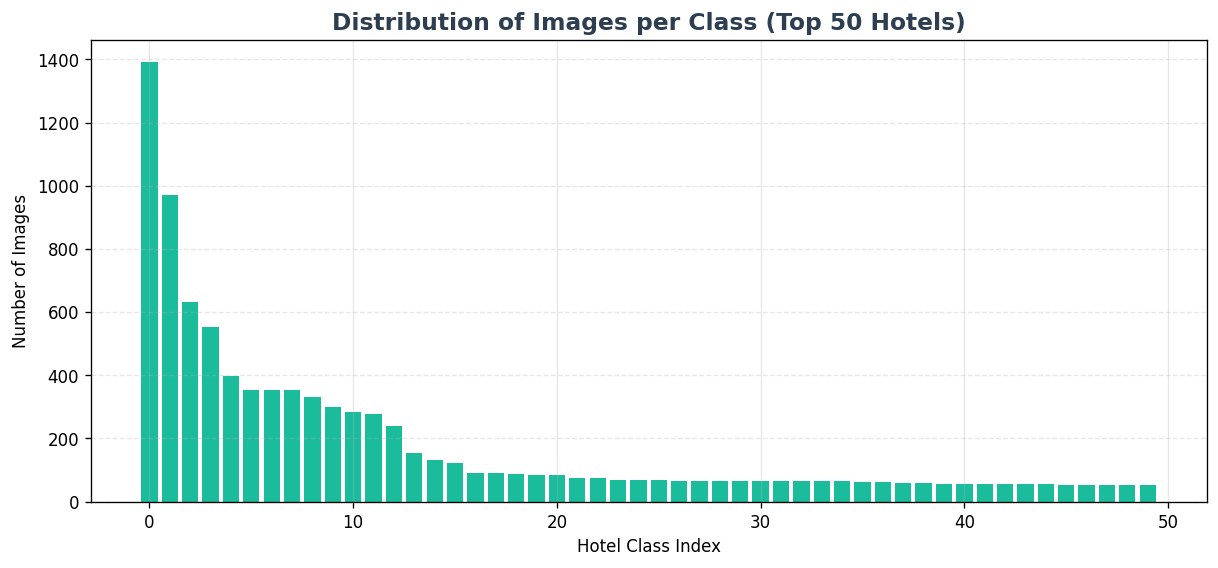

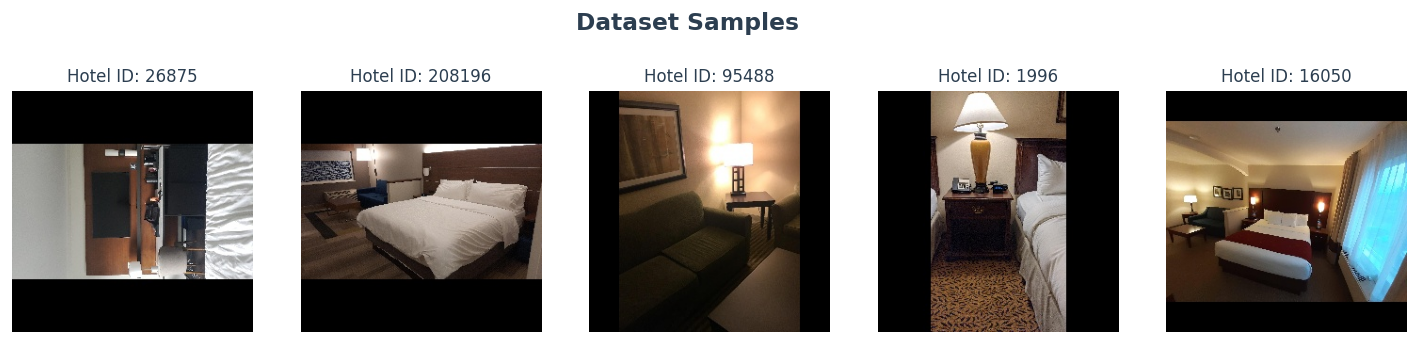

Train Set: 7256 | Test Set: 1814


In [8]:
# Load Data
df = pd.read_csv(CSV_PATH)

# Handle potential path formats
if 'chain_id' in df.columns:
    df['filepath'] = df['chain_id'].astype(str) + '/' + df['image_id']
else:
    df['filepath'] = df['image_id']

# Filter Top N Classes
hotel_counts = df['hotel_id'].value_counts()
top_hotels = hotel_counts.head(TOP_N_CLASSES).index
df_filtered = df[df['hotel_id'].isin(top_hotels)].copy()

# Map Labels (0 to N-1)
label_map = {original: new for new, original in enumerate(top_hotels)}
df_filtered['label'] = df_filtered['hotel_id'].map(label_map)

# --- VISUALIZATION 1: DATA DISTRIBUTION ---
plt.figure(figsize=(12, 5))
counts = df_filtered['hotel_id'].value_counts().values
plt.bar(range(len(counts)), counts, color=PALETTE['bar1'])
plt.title(f"Distribution of Images per Class (Top {TOP_N_CLASSES} Hotels)", fontsize=14, fontweight='bold', color=PALETTE['primary'])
plt.xlabel("Hotel Class Index")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--')
plt.show()

# --- VISUALIZATION 2: SAMPLE IMAGES ---
def show_samples():
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    samples = df_filtered.sample(5)
    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            img = Image.open(os.path.join(IMAGE_DIR, row['filepath']))
            axes[i].imshow(img)
            axes[i].set_title(f"Hotel ID: {row['hotel_id']}", fontsize=10, color=PALETTE['primary'])
            axes[i].axis('off')
        except:
            pass
    plt.suptitle("Dataset Samples", fontsize=14, y=1.05, fontweight='bold', color=PALETTE['primary'])
    plt.show()

show_samples()

# --- 80/20 SPLIT ---
train_df, test_df = train_test_split(
    df_filtered, test_size=0.20, stratify=df_filtered['label'], random_state=42
)
print(f"Train Set: {len(train_df)} | Test Set: {len(test_df)}")

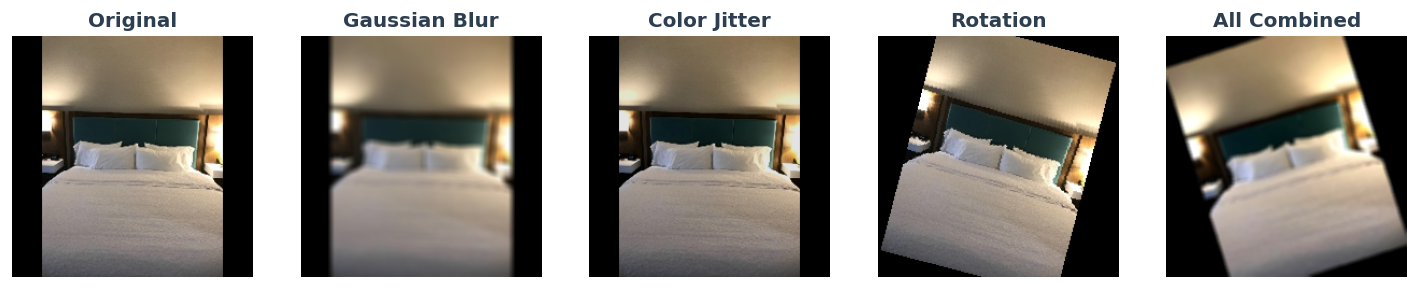

In [9]:
# --- AUGMENTATION PIPELINE (Fixed to 224) ---
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Now 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Now 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class HotelDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = Image.open(os.path.join(self.root_dir, row['filepath'])).convert('RGB')
        except:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
        label = row['label']
        if self.transform: image = self.transform(image)
        return image, label

# --- VISUALIZATION (Updated) ---
def viz_aug():
    row = train_df.iloc[0]
    orig = Image.open(os.path.join(IMAGE_DIR, row['filepath'])).resize((IMG_SIZE, IMG_SIZE))
    
    aug_list = [
        ("Original", transforms.Compose([])),
        ("Gaussian Blur", transforms.GaussianBlur(7, 5)),
        ("Color Jitter", transforms.ColorJitter(0.5, 0.5)),
        ("Rotation", transforms.RandomRotation(30)),
        ("All Combined", transforms.Compose([
            transforms.RandomRotation(30), transforms.ColorJitter(0.3, 0.3), transforms.GaussianBlur(5, 3)
        ]))
    ]
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for i, (name, t) in enumerate(aug_list):
        img_aug = t(orig)
        axes[i].imshow(img_aug)
        axes[i].set_title(name, color=PALETTE['primary'], fontweight='bold')
        axes[i].axis('off')
    plt.show()

viz_aug()

# Loaders
train_loader = DataLoader(HotelDataset(train_df, IMAGE_DIR, train_transforms), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(HotelDataset(test_df, IMAGE_DIR, val_transforms), batch_size=BATCH_SIZE)

In [11]:
# --- 1. CUSTOM CNN (Feature-Rich but Lightweight) ---
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Attention Block"""
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class CustomHotelCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomHotelCNN, self).__init__()
        # 4 Convolutional Blocks with SE Attention
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            SEBlock(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            SEBlock(128),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            SEBlock(256),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# --- 2. SOTA MODEL FACTORY ---
def get_model(name, num_classes):
    if name == "Custom CNN":
        return CustomHotelCNN(num_classes)
    elif name == "ResNet":
        return timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=num_classes)
    elif name == "EfficientNetV2":
        return timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=True, num_classes=num_classes)
    elif name == "ConvNeXt V2":
        return timm.create_model('convnextv2_tiny.fcmae_ft_in22k_in1k', pretrained=True, num_classes=num_classes)
    elif name == "Swin":
        return timm.create_model('swin_tiny_patch4_window7_224.ms_in1k', pretrained=True, num_classes=num_classes)
    elif name == "ViT":
        return timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', pretrained=True, num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")

print("Architectures Defined.")

Architectures Defined.


In [12]:
def train_engine(model_name, epochs=EPOCHS, lr=LR):
    print(f"\n--- Training {model_name} ---")
    model = get_model(model_name, TOP_N_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) # Fixed LR as requested
    
    history = {'train_loss': [], 'test_loss': [], 'top1': [], 'top5': [], 'map5': []}
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for img, lbl in train_loader:
            img, lbl = img.to(device), lbl.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, lbl)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # Eval
        model.eval()
        test_loss, t1, t5, map5_sum, total = 0, 0, 0, 0, 0
        with torch.no_grad():
            for img, lbl in test_loader:
                img, lbl = img.to(device), lbl.to(device)
                out = model(img)
                loss = criterion(out, lbl)
                test_loss += loss.item()
                
                # Metrics
                probs = torch.softmax(out, dim=1)
                _, topk = torch.topk(probs, 5, dim=1)
                
                total += lbl.size(0)
                for i in range(lbl.size(0)):
                    true = lbl[i].item()
                    preds = topk[i].cpu().numpy()
                    
                    if preds[0] == true: t1 += 1
                    if true in preds: 
                        t5 += 1
                        rank = np.where(preds == true)[0][0] + 1
                        map5_sum += 1.0/rank

        # Store Stats
        history['train_loss'].append(train_loss/len(train_loader))
        history['test_loss'].append(test_loss/len(test_loader))
        history['top1'].append(t1/total*100)
        history['top5'].append(t5/total*100)
        history['map5'].append(map5_sum/total)
        
        print(f"Epoch {epoch+1}: Test Loss {history['test_loss'][-1]:.4f} | Top1 {history['top1'][-1]:.2f}%")
        
    return history

# --- EXECUTE PHASE 1 ---
models_list = ["Custom CNN", "ResNet", "EfficientNetV2", "ConvNeXt V2", "Swin", "ViT"]
phase1_results = {}

for m_name in models_list:
    phase1_results[m_name] = train_engine(m_name)


--- Training Custom CNN ---
Epoch 1: Test Loss 2.5195 | Top1 34.67%
Epoch 2: Test Loss 2.3068 | Top1 35.50%
Epoch 3: Test Loss 1.9267 | Top1 51.93%
Epoch 4: Test Loss 1.9069 | Top1 49.61%
Epoch 5: Test Loss 1.6746 | Top1 57.39%

--- Training ResNet ---
Epoch 1: Test Loss 2.9820 | Top1 20.73%
Epoch 2: Test Loss 2.3182 | Top1 43.38%
Epoch 3: Test Loss 1.6972 | Top1 61.41%
Epoch 4: Test Loss 1.3762 | Top1 66.21%
Epoch 5: Test Loss 1.1801 | Top1 71.17%

--- Training EfficientNetV2 ---
Epoch 1: Test Loss 1.3545 | Top1 68.14%
Epoch 2: Test Loss 0.8612 | Top1 79.44%
Epoch 3: Test Loss 0.6644 | Top1 84.40%
Epoch 4: Test Loss 0.5968 | Top1 86.16%
Epoch 5: Test Loss 0.5318 | Top1 88.09%

--- Training ConvNeXt V2 ---
Epoch 1: Test Loss 0.7953 | Top1 81.92%
Epoch 2: Test Loss 0.4504 | Top1 89.97%
Epoch 3: Test Loss 0.3716 | Top1 91.12%
Epoch 4: Test Loss 0.2952 | Top1 92.83%
Epoch 5: Test Loss 0.2802 | Top1 93.33%

--- Training Swin ---
Epoch 1: Test Loss 0.7211 | Top1 82.58%
Epoch 2: Test Loss 0

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: Test Loss 1.0497 | Top1 72.82%
Epoch 2: Test Loss 0.7232 | Top1 81.48%
Epoch 3: Test Loss 0.5042 | Top1 86.27%
Epoch 4: Test Loss 0.5313 | Top1 87.10%
Epoch 5: Test Loss 0.5824 | Top1 87.21%


Visualization for all 6 models:

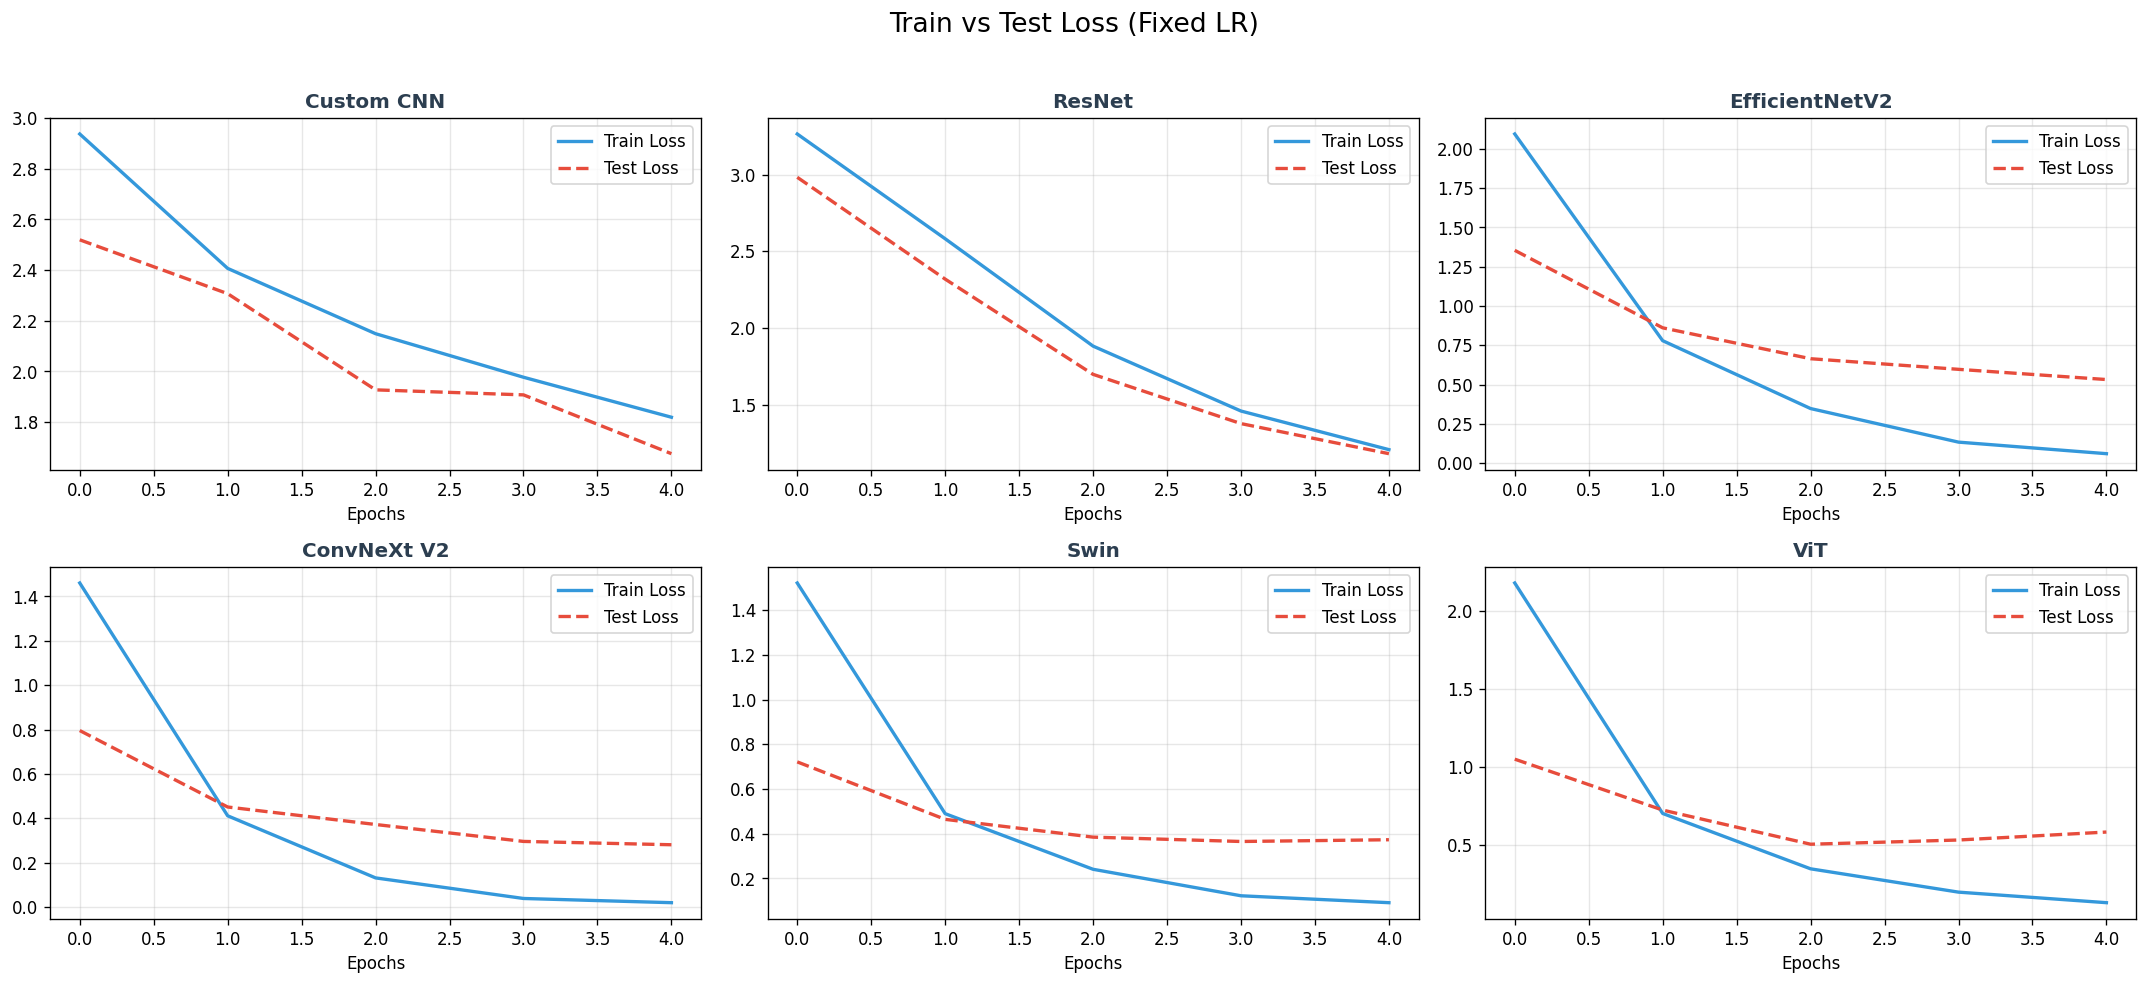

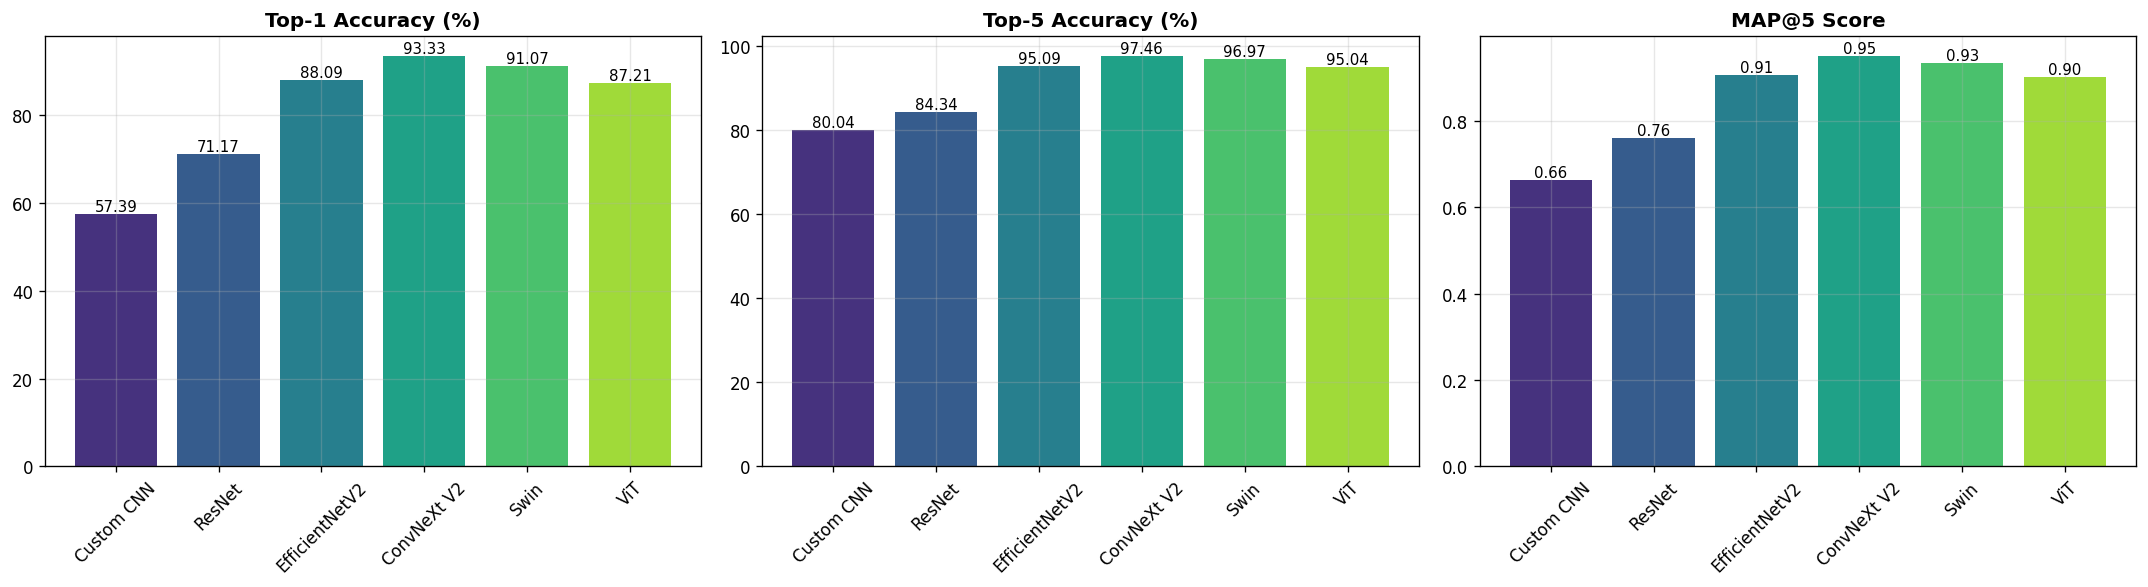

In [13]:
# --- VIZ 1: LOSS CURVES ---
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, m_name in enumerate(models_list):
    h = phase1_results[m_name]
    axes[i].plot(h['train_loss'], label='Train Loss', color=PALETTE['train'], linewidth=2)
    axes[i].plot(h['test_loss'], label='Test Loss', color=PALETTE['test'], linewidth=2, linestyle='--')
    axes[i].set_title(m_name, fontweight='bold', color=PALETTE['primary'])
    axes[i].set_xlabel("Epochs")
    axes[i].legend()

plt.suptitle("Train vs Test Loss (Fixed LR)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# --- VIZ 2: METRIC COMPARISON ---
metrics = ['top1', 'top5', 'map5']
titles = ['Top-1 Accuracy (%)', 'Top-5 Accuracy (%)', 'MAP@5 Score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(metrics):
    vals = [phase1_results[m][metric][-1] for m in models_list]
    colors = sns.color_palette("viridis", len(models_list))
    bars = axes[i].bar(models_list, vals, color=colors)
    axes[i].set_title(titles[i], fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Label bars
    for bar in bars:
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                     f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Phase 2: ViT Optimization (ARface + Scheduler)

In [14]:
# --- ARCFACE LOSS MODULE ---
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# --- ADVANCED TRAINING ENGINE ---
def train_vit_advanced(use_arcface=False):
    exp_name = "ViT + ArcFace" if use_arcface else "ViT + CE + Scheduler"
    print(f"\n--- Running Experiment: {exp_name} ---")
    
    # Load ViT
    model = get_model("ViT", TOP_N_CLASSES)
    
    # If ArcFace, we need the raw features before classification
    if use_arcface:
        # Replace head with Identity to get embeddings, create separate ArcFace head
        embed_dim = model.head.in_features
        model.head = nn.Identity()
        metric_fc = ArcFaceLoss(embed_dim, TOP_N_CLASSES).to(device)
        optimizer = optim.Adam([{'params': model.parameters()}, {'params': metric_fc.parameters()}], lr=LR)
    else:
        optimizer = optim.Adam(model.parameters(), lr=LR)
        criterion = nn.CrossEntropyLoss()
        
    model = model.to(device)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    history = {'train_loss': [], 'test_loss': [], 'top1': [], 'top5': [], 'map5': []}
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for img, lbl in train_loader:
            img, lbl = img.to(device), lbl.to(device)
            optimizer.zero_grad()
            
            features = model(img)
            
            if use_arcface:
                out = metric_fc(features, lbl)
                loss = nn.CrossEntropyLoss()(out, lbl)
            else:
                loss = criterion(features, lbl)
                
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # Eval
        model.eval()
        test_loss, t1, t5, map5_sum, total = 0, 0, 0, 0, 0
        with torch.no_grad():
            for img, lbl in test_loader:
                img, lbl = img.to(device), lbl.to(device)
                features = model(img)
                
                if use_arcface:
                    # For inference, ArcFace uses cosine sim against weights
                    cosine = F.linear(F.normalize(features), F.normalize(metric_fc.weight))
                    out = cosine * 30.0 # Scale back up
                    loss = nn.CrossEntropyLoss()(out, lbl)
                else:
                    out = features
                    loss = criterion(out, lbl)
                    
                test_loss += loss.item()
                
                # Metrics
                probs = torch.softmax(out, dim=1)
                _, topk = torch.topk(probs, 5, dim=1)
                total += lbl.size(0)
                for i in range(lbl.size(0)):
                    true = lbl[i].item()
                    preds = topk[i].cpu().numpy()
                    if preds[0] == true: t1 += 1
                    if true in preds: 
                        t5 += 1
                        rank = np.where(preds == true)[0][0] + 1
                        map5_sum += 1.0/rank
                        
        # Step Scheduler
        avg_test_loss = test_loss/len(test_loader)
        scheduler.step(avg_test_loss)
        
        # Log
        history['train_loss'].append(train_loss/len(train_loader))
        history['test_loss'].append(avg_test_loss)
        history['top1'].append(t1/total*100)
        history['top5'].append(t5/total*100)
        history['map5'].append(map5_sum/total)
        print(f"Epoch {epoch+1}: Test Loss {avg_test_loss:.4f} | Top1 {history['top1'][-1]:.2f}%")
        
    return model, history

# --- EXECUTE PHASE 2 ---
# 1. ViT + CrossEntropy + Scheduler
vit_ce_model, vit_ce_hist = train_vit_advanced(use_arcface=False)

# 2. ViT + ArcFace + Scheduler
vit_arc_model, vit_arc_hist = train_vit_advanced(use_arcface=True)


--- Running Experiment: ViT + CE + Scheduler ---
Epoch 1: Test Loss 1.4627 | Top1 63.73%
Epoch 2: Test Loss 0.8869 | Top1 77.56%
Epoch 3: Test Loss 0.6595 | Top1 83.85%
Epoch 4: Test Loss 0.5693 | Top1 86.16%
Epoch 5: Test Loss 0.5755 | Top1 86.49%

--- Running Experiment: ViT + ArcFace ---
Epoch 1: Test Loss 1.4122 | Top1 74.15%
Epoch 2: Test Loss 0.9859 | Top1 83.13%
Epoch 3: Test Loss 1.2025 | Top1 83.41%
Epoch 4: Test Loss 1.0772 | Top1 85.56%
Epoch 5: Test Loss 1.1340 | Top1 85.17%


Phase 2 Visualization:

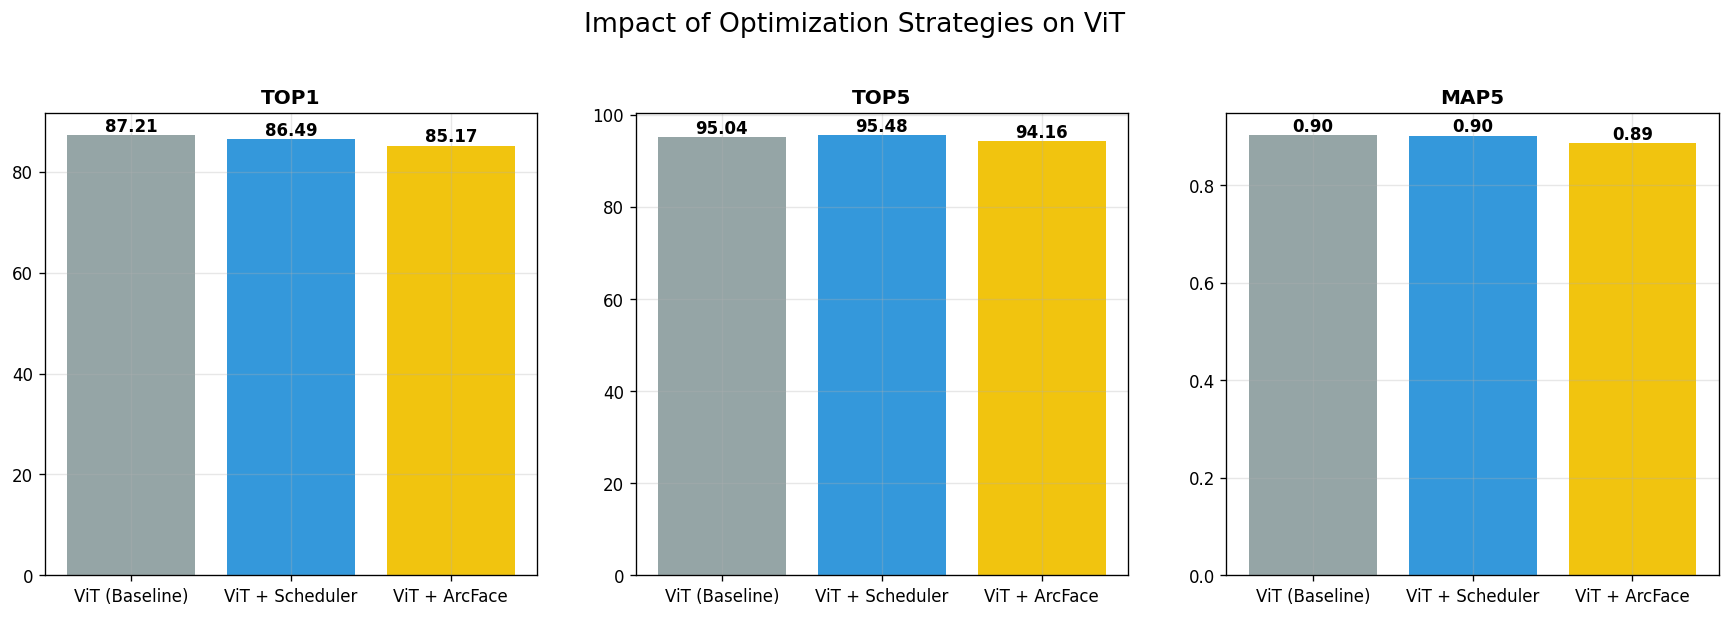

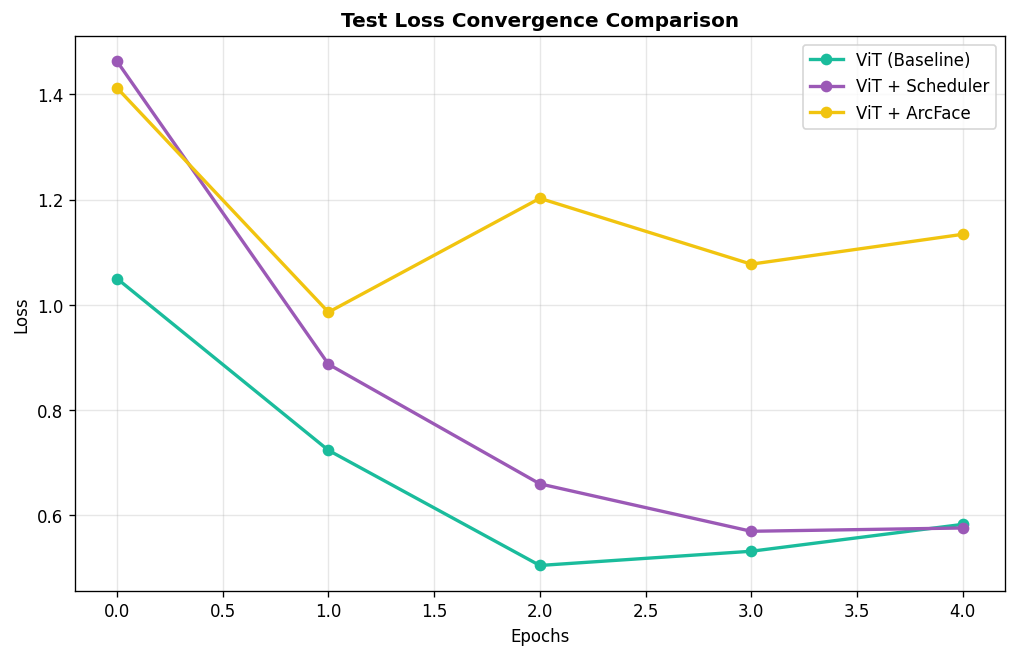

In [15]:
# Gather Data
histories = {
    'ViT (Baseline)': phase1_results['ViT'],
    'ViT + Scheduler': vit_ce_hist,
    'ViT + ArcFace': vit_arc_hist
}

# Plot Metric Comparison
metrics = ['top1', 'top5', 'map5']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    vals = [h[metric][-1] for h in histories.values()]
    names = list(histories.keys())
    
    # Colors: Grey for baseline, Blue for Scheduler, Gold for ArcFace
    colors = ['#95a5a6', PALETTE['train'], '#f1c40f']
    
    bars = axes[i].bar(names, vals, color=colors)
    axes[i].set_title(metric.upper(), fontweight='bold')
    
    for bar in bars:
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                     f'{bar.get_height():.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle("Impact of Optimization Strategies on ViT", fontsize=16, y=1.05)
plt.show()

# Plot Loss Curves Comparison
plt.figure(figsize=(10, 6))
for name, h in histories.items():
    plt.plot(h['test_loss'], label=name, marker='o', linewidth=2)
plt.title("Test Loss Convergence Comparison", fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Feature Analysis and GRAD-CAM

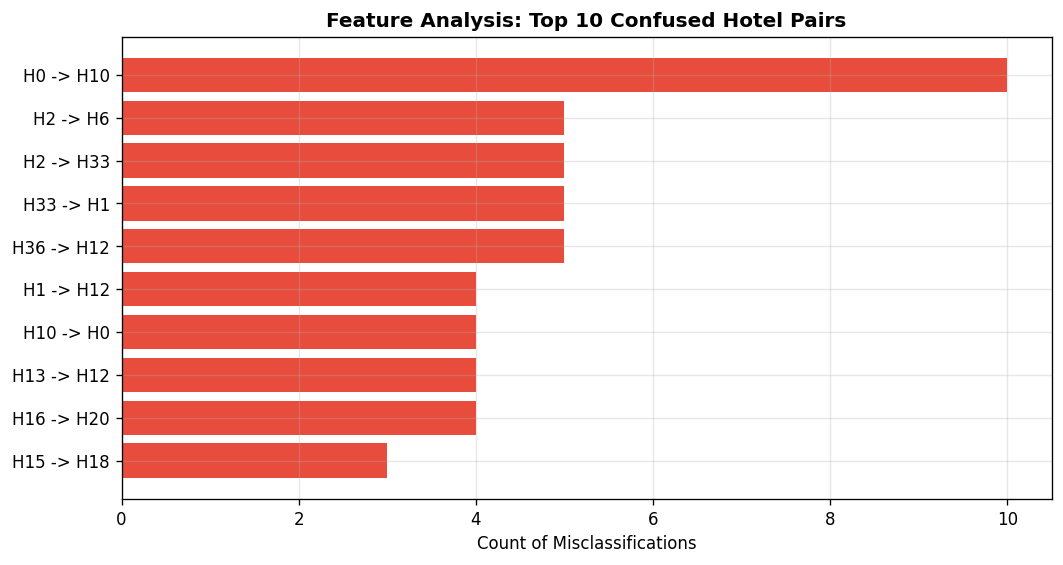

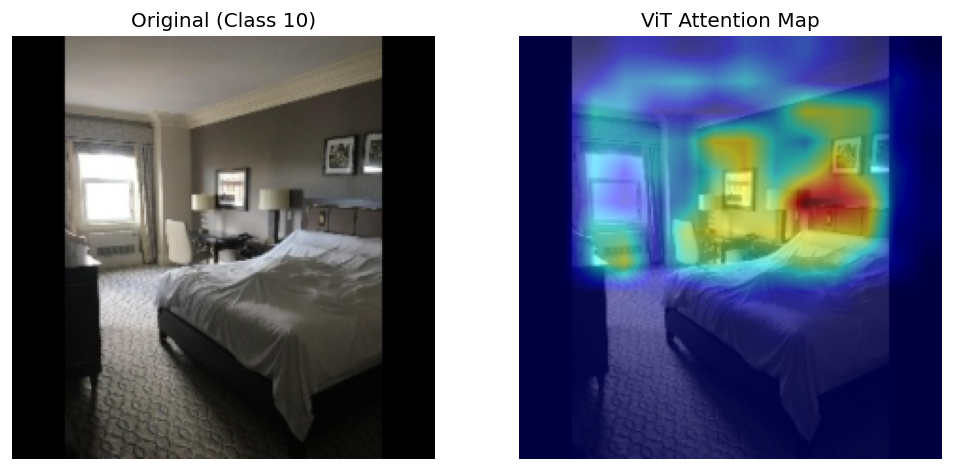

In [21]:
!pip install -q grad-cam

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from sklearn.metrics import confusion_matrix

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# --- 1. FEATURE ANALYSIS (CONFUSION MATRIX) ---
def plot_confusion_analysis(model, loader):
    model.eval()
    all_preds, all_lbls = [], []
    with torch.no_grad():
        for img, lbl in loader:
            img = img.to(device)
            out = model(img)
            _, pred = torch.max(out, 1)
            all_preds.extend(pred.cpu().numpy())
            all_lbls.extend(lbl.numpy())
            
    cm = confusion_matrix(all_lbls, all_preds)
    np.fill_diagonal(cm, 0) # Focus on errors
    
    pairs = []
    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            if cm[r,c] > 0:
                pairs.append({'name': f"H{r} -> H{c}", 'count': cm[r,c]})
    
    # Top 10 Errors
    pairs = sorted(pairs, key=lambda x: x['count'], reverse=True)[:10]
    
    if not pairs:
        print("No errors found to visualize!")
        return

    plt.figure(figsize=(10, 5))
    plt.barh([p['name'] for p in pairs], [p['count'] for p in pairs], color=PALETTE['test'])
    plt.gca().invert_yaxis()
    plt.title("Feature Analysis: Top 10 Confused Hotel Pairs", fontweight='bold')
    plt.xlabel("Count of Misclassifications")
    plt.show()

plot_confusion_analysis(vit_ce_model, test_loader)

# --- 2. GRAD-CAM VISUALIZATION (With ViT Reshape Fix) ---

# CRITICAL FIX: Helper to reshape 1D ViT tokens back to 2D image
def vit_reshape_transform(tensor):
    # Tensor shape is [Batch, Tokens, Channels] (e.g., [1, 197, 768])
    # The first token is [CLS], we drop it
    height = 14
    width = 14
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    
    # Bring channels to the front: [B, H, W, C] -> [B, C, H, W]
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def viz_gradcam(model, idx=0):
    model.eval()
    
    # Target the last LayerNorm before the head
    target_layer = model.blocks[-1].norm1
    
    img_tensor, label = test_loader.dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Pass the reshape_transform function here
    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
    
    # Denormalize
    inv_norm = transforms.Compose([ 
        transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
    ])
    rgb_img = inv_norm(img_tensor).permute(1, 2, 0).cpu().numpy()
    rgb_img = np.clip(rgb_img, 0, 1)
    
    viz = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(rgb_img)
    ax[0].set_title(f"Original (Class {label})")
    ax[0].axis('off')
    
    ax[1].imshow(viz)
    ax[1].set_title("ViT Attention Map")
    ax[1].axis('off')
    plt.show()

# Run visualization
viz_gradcam(vit_ce_model, idx=15)

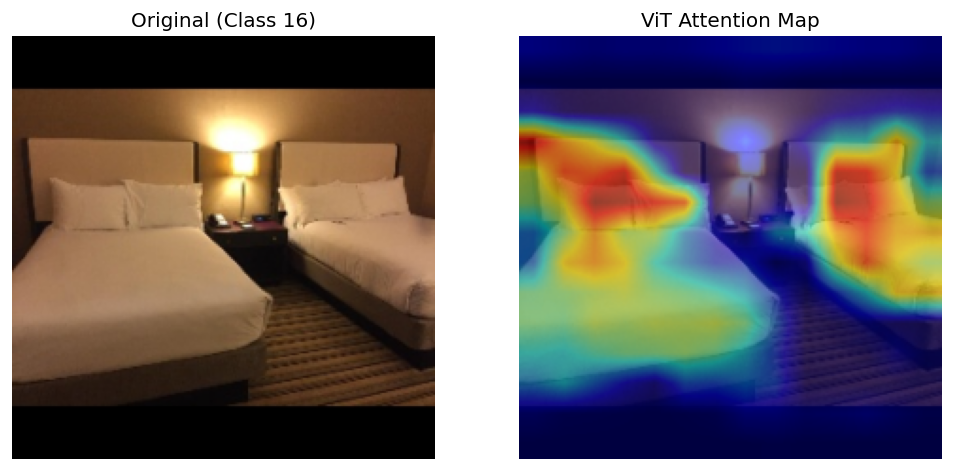

In [27]:
# Run visualization
viz_gradcam(vit_ce_model, idx=11)

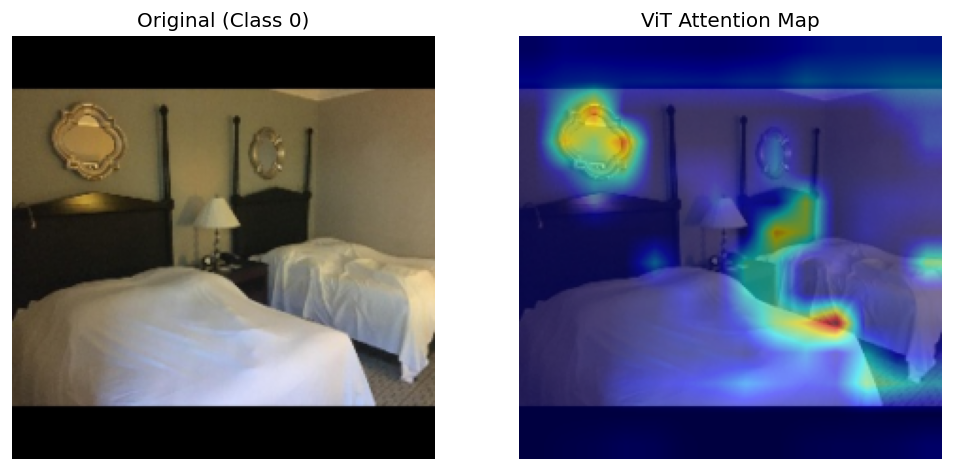

In [24]:
# Run visualization
viz_gradcam(vit_ce_model, idx=-2)